### Initializations & Parameters

In [131]:
### installing dependencies
#%pip install gymnasium matplotlib tqdm numpy pandas
### install the environment package
#%pip install -e GRL
###

#### Imports

In [132]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *
import pandas as pd


In [133]:
## matplotlib figure size parameters
plt.rcParams["figure.figsize"] = (10, 7)
colors = [
    "violet",
    "purple",
    "red",
    "sienna",
    "darkorange",
    "burlywood",
    "gold",
    "darkgoldenrod",
    "olivedrab",
    "lawngreen",
    "deepskyblue",
    "steelblue",
]
## full hexad type names
hexad_types_full = [
    "Player",
    "Achiever",
    "Philanthropist",
    "Disruptor",
    "Socializer",
    "Free Spirit",
]

#### Environment Initialization

In [134]:
## First set of gamification elements
corr_g_e = list(corr_gamification_elements.values())
## Second set of gamification elements
sample_g_e = list(sample_gamification_elements.values())
## this test runs using half the elements of the second set
g_e = sample_g_e[1::2]
ge2c = {"Nothing": "black"}
for i in range(len(g_e)):
    ge2c[g_e[i].name] = colors[i]

#### Functions used for testing, plotting and evaluating metrics

In [135]:
def test_env_agent(
    env,
    agent,
    answer_bot,
    test_iterations,
    retrain_iterations,
    random_retrain,
    training_lr,
):
    rewards = []
    choices = []
    best = []
    agent_error = []
    actions = defaultdict(lambda: {"x": [], "y": []})
    hexad_diff = []
    hd_stats = {"mean": [], "std": []}
    obs, info = env.reset()
    for i in tqdm(range(test_iterations), leave=False):
        best.append(env.get_best_action())
        act = agent.get_action(obs, avoid_reps=True)
        h_type = env.ge[env.action_to_ge[act]].type
        answer, _ = answer_bot.get_answer(h_type)
        choice, reward, new_obs, info, error = agent.step_and_update(
            env=env,
            obs=obs,
            answer=answer,
            retrain_iterations=retrain_iterations,
            learning_rate=training_lr,
            random_retrain=random_retrain,
            act=act,
        )
        choices.append(choice)
        rewards.append(reward)
        agent_error.append(error)
        actions[choice]["x"].append(i)
        actions[choice]["y"].append(reward)
        diff = 0
        d_s = []
        for typ, val in answer_bot.hexad_profile.items():
            v = abs(val - env.hexad_adjusted[typ])
            diff += v
            d_s.append(v)
        hd_stats["mean"].append(np.mean(d_s))
        hd_stats["std"].append(np.std(d_s))
        hexad_diff.append(diff)
        obs = new_obs
    return (
        rewards,
        choices,
        best,
        agent_error,
        actions,
        (obs, info),
        hexad_diff,
        hd_stats,
    )

In [136]:
def plot_actions(actions, env, title=None, f=1):
    typ = "pl"
    fig = plt.figure(f, figsize=(15, 10))
    fig.suptitle(title)
    for i, _ in sorted(actions.items()):
        name = env.action_to_ge[i]
        hex_type = env.ge[name].type
        if hex_type != None:
            plt.figure(f)
            type_index = hexad_types.index(env.ge[name].type) + 1
        else:
            type_index = 7
        plt.subplot(7, 1, type_index)
        plt.ylim(0, 800)
        plt.scatter(actions[i]["x"], actions[i]["y"], label=name, s=2, color=ge2c[name])
        ax = plt.gca()
        ax.legend()
    plt.figure(f + 1)
    fig.suptitle(title)
    for i in actions:
        plt.scatter(
            actions[i]["x"],
            actions[i]["y"],
            label=env.action_to_ge[i],
            s=5,
            color=ge2c[env.action_to_ge[i]],
        )
        ax = plt.gca()
        ax.legend()

In [137]:
def plot_actionsX(actions, env, title=None, f=1, X=200):
    typ = "pl"
    fig = plt.figure(f, figsize=(12, 6))
    fig.suptitle(
        "Actions and Rewards over time by element Hexad type\nAgent: {}".format(
            title
        )
    )
    for i, _ in sorted(actions.items()):
        name = env.action_to_ge[i]
        hex_type = env.ge[name].type
        if hex_type != None:
            plt.figure(f)
            type_index = hexad_types.index(env.ge[name].type) + 1
        else:
            type_index = 8
        Eks = np.array(actions[i]["x"])
        Psi = np.array(actions[i]["y"])
        Psi = Psi[Eks <= X]
        Eks = Eks[Eks <= X]
        plt.subplot(3, 3, type_index)
        fig.tight_layout(pad=1.0)
        plt.xlim(0, X)
        plt.ylim(0, 800)
        if type_index in [1, 4, 8]:
            plt.ylabel("Reward")
        if type_index in [4, 6, 8]:
            plt.xlabel("")
        ax = plt.gca()
        if hex_type != None:
            ax.set_title(hexad_types_full[type_index - 1])
        else:
            ax.set_title("Nothing")
        if Eks.size == 0 or Psi.size == 0:
            continue
        plt.scatter(Eks, Psi, label=name, s=2, color=ge2c[name])
        ax.legend()
    fig = plt.figure(f + 1, figsize=(12, 7))
    for i in actions:
        plt.scatter(
            actions[i]["x"],
            actions[i]["y"],
            label=env.action_to_ge[i],
            s=5,
            color=ge2c[env.action_to_ge[i]],
        )
        plt.xlim(0, 500)
        plt.ylabel("Reward")
        fig.suptitle("Actions and Rewards over time\nAgent: {}".format(title))
        plt.xlabel("")
        ax = plt.gca()
        ax.legend()

In [138]:
def get_stats(actions, best, choices):
    type_stats = defaultdict(lambda: 0)
    for i in actions:
        try:
            type_stats[sample_gamification_elements[env.action_to_ge[i]].type] += len(
                actions[i]["x"]
            )
        except KeyError:
            type_stats["None"] += len(actions[i]["x"])
    s = 0
    for i in range(len(best)):
        if best[i][1] == choices[i][1]:
            s += 1
    diff = [best[i][1] - choices[i][1] for i in range(len(choices))]
    actual = pd.Series([env.action_to_ge[item[0]] for item in best], name="Actual Best")
    pred = pd.Series([env.action_to_ge[item[0]] for item in b], name="Predicted Best")
    conf_matrix = pd.crosstab(actual, pred, margins=True)
    return type_stats, s / len(best), diff, conf_matrix

#### Environment Initialization

In [139]:
## User Hexad profile 
hexad = hexad_load_dict(pl=2, ach=5, ph=4, dis=0.5, s=1, fs=3).load_dict

In [140]:
## Environment parameters
fatigue_penalty = 0.05
fatigue_replenishment = 0.01
nothing_reward = 75
ranges = (1.0, 1.3, 1.7)
increase = (0.1, 0.05, 0.025)
decrease = (0.05, 0.05, 0.05)
pref_min = 0.2
seed = 10101
env = gym.make(
    "GamificationRL/GamificationPreferenceEnv-v0",
    hexad_load=hexad,
    gamification_elements=g_e,
    use_fatigue=True,
    individual_modifications=None,
    repetition_penalty=(400, 800),
    nothing_reward=nothing_reward,
    fatigue_reduction=fatigue_penalty,
    fatigue_replenish=fatigue_replenishment,
    pref_ranges=ranges,
    pref_increase=increase,
    pref_decrease=decrease,
    pref_min=pref_min,
    seed=seed,
)
obs, _ = env.reset()

#### Answer Simulation Initialization

In [141]:
uncertainty = 0.1
divisor = 5.5
starting_threshold = 0.1
gain_modifier = 0.02
amount = 1
ht = copy.deepcopy(hexad)

In [142]:
bot = ScoreChangeBot(
    hexad_types=copy.deepcopy(ht),
    uncertainty=uncertainty,
    divisor=divisor,
    starting_change_threshold=starting_threshold,
    change_gain_modifier=gain_modifier,
    change_amount=amount,
    seed=seed,
)

#### Agent Initialization

##### Fatigue-Aware

In [143]:
# Fatigue-aware parameters
learn_rate = 0.002
discount_factor = 0.7
epsilon = 1
epsilon_min = 0.025
training_iterations = int(1e5)
epsilon_decay = (epsilon - epsilon_min) / (training_iterations * 3 / 4000)

In [144]:
fa_agent = FatigueAwareAgent(
    learn_rate=learn_rate,
    discount_factor=discount_factor,
    env=env,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
)
train_error = fa_agent.train(env=env, iterations=training_iterations, trunc_error=True)

##### Epsilon

In [145]:
# Epsilon agent parameters
learn_rate = 0.002
discount_factor = 0.7
epsilon = 1
epsilon_min = 0.025
training_iterations = int(1e5)
epsilon_decay = (epsilon - epsilon_min) / (training_iterations * 3 / 4000)

In [146]:
e_agent = EpsilonAGAgent(
    learn_rate=learn_rate,
    discount_factor=discount_factor,
    env=env,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
)

train_error = e_agent.train(env=env, iterations=training_iterations, trunc_error=True)

##### Basic

In [147]:
# Basic agent parameters
learn_rate = 0.002
discount_factor = 0.7
basic_agent = BasicAGAgent(
    learn_rate=learn_rate,
    discount_factor=discount_factor,
    env=env,
)
train_error = basic_agent.train(
    env=env, iterations=training_iterations, trunc_error=True
)

##### Best of X

In [148]:
# RandomBestOfX parameters
learn_rate = 0.002
discount_factor = 0.7
epsilon = 1
epsilon_min = 0.1
training_iterations = int(1e5)
epsilon_decay = (epsilon - epsilon_min) / (training_iterations * 4 / 5000)
x = 3

In [149]:
boX_agent = RandomBestOfX(
    learn_rate=learn_rate,
    discount_factor=discount_factor,
    env=env,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    X=x,
)

train_error = boX_agent.train(env=env, iterations=training_iterations, trunc_error=True)

##### All agents

In [150]:
agents = {
    "Basic": basic_agent,
    "Epsilon": e_agent,
    "BestOfX": boX_agent,
    "FatigueAware": fa_agent,
}

### Run

In [151]:
## Set number of tests to perform, 
## number of retraining iterations after every action and
## the learning rate used during retraining.
tests = 500
retrains = 1000
retrain_learn_rate = 0.3

In [152]:
rewards = {}
choices = {}
best_choices = {}
agent_error = {}
actions = {}
profile_diff = {}
prof_stats = {}
for name, agent in agents.items():
    bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(ht),
        uncertainty=uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )
    print(name)
    random_retrain = name in ["Basic", "BestOfX"]
    r, c, b, e, a, _, hd, hds = test_env_agent(
        env,
        agent,
        answer_bot=bot,
        test_iterations=tests,
        retrain_iterations=retrains,
        random_retrain=random_retrain,
        training_lr=retrain_learn_rate,
    )
    rewards[name] = r
    choices[name] = c
    best_choices[name] = b
    agent_error[name] = e
    actions[name] = a
    profile_diff[name] = hd
    prof_stats[name] = hds

type_stats = {}
accuracies = {}
diff_from_best = {}
confusion_matrices = {}
for agent in agents:
    t, acc, diff, conf_matrix = get_stats(
        actions[agent], best_choices[agent], [*zip(choices[agent], rewards[agent])]
    )
    type_stats[agent] = t
    accuracies[agent] = acc
    diff_from_best[agent] = diff
    confusion_matrices[agent] = conf_matrix

Basic


  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\User\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.get_best_action to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_best_action` for environment variables or `env.get_attr('get_best_action')` that will search the reminding wrappers.
  logger.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.ge to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ge` for environment variables or `env.get_attr('ge')` that will search the reminding wrappers.
  logger.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.action_to_ge to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can

Epsilon


BestOfX


FatigueAware


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.action_to_ge to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_to_ge` for environment variables or `env.get_attr('action_to_ge')` that will search the reminding wrappers.
  logger.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.action_to_ge to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_to_ge` for environment variables or `env.get_attr('action_to_ge')` that will search the reminding wrappers.
  logger.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.action_to_ge to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped

### Results

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.action_to_ge to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_to_ge` for environment variables or `env.get_attr('action_to_ge')` that will search the reminding wrappers.
  logger.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.ge to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ge` for environment variables or `env.get_attr('ge')` that will search the reminding wrappers.
  logger.warn(


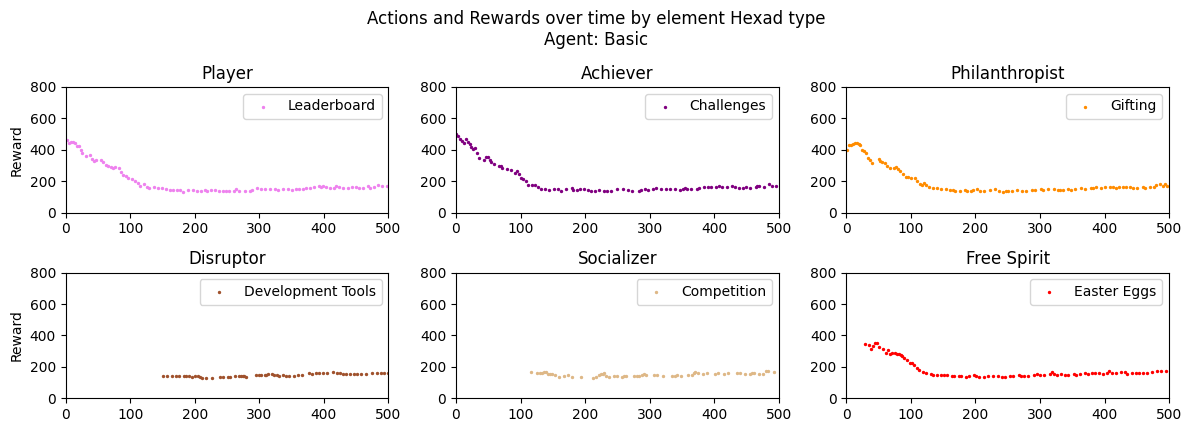

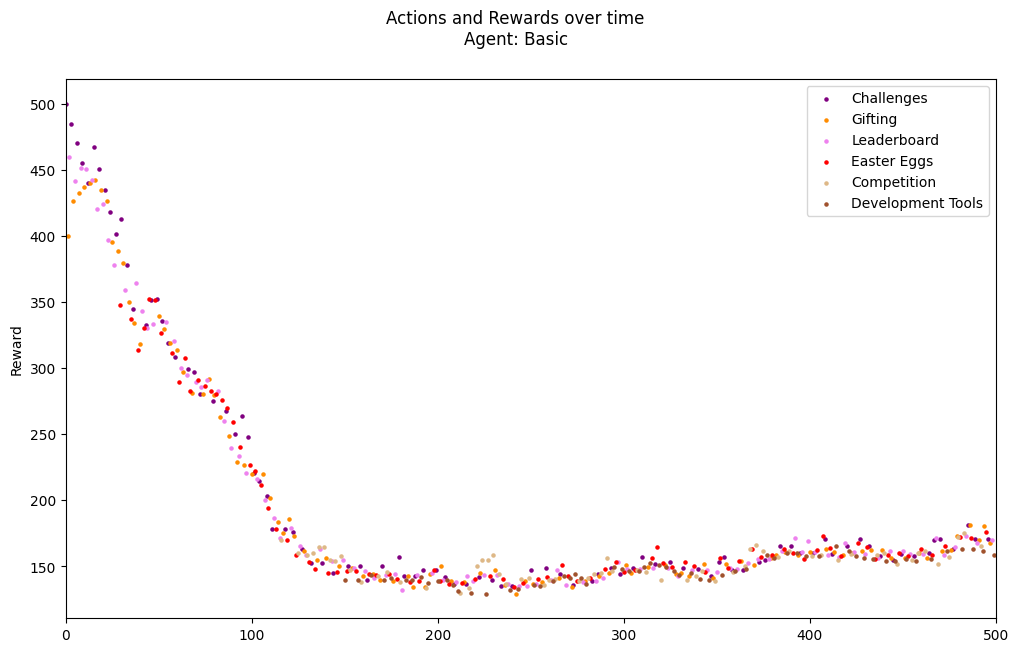

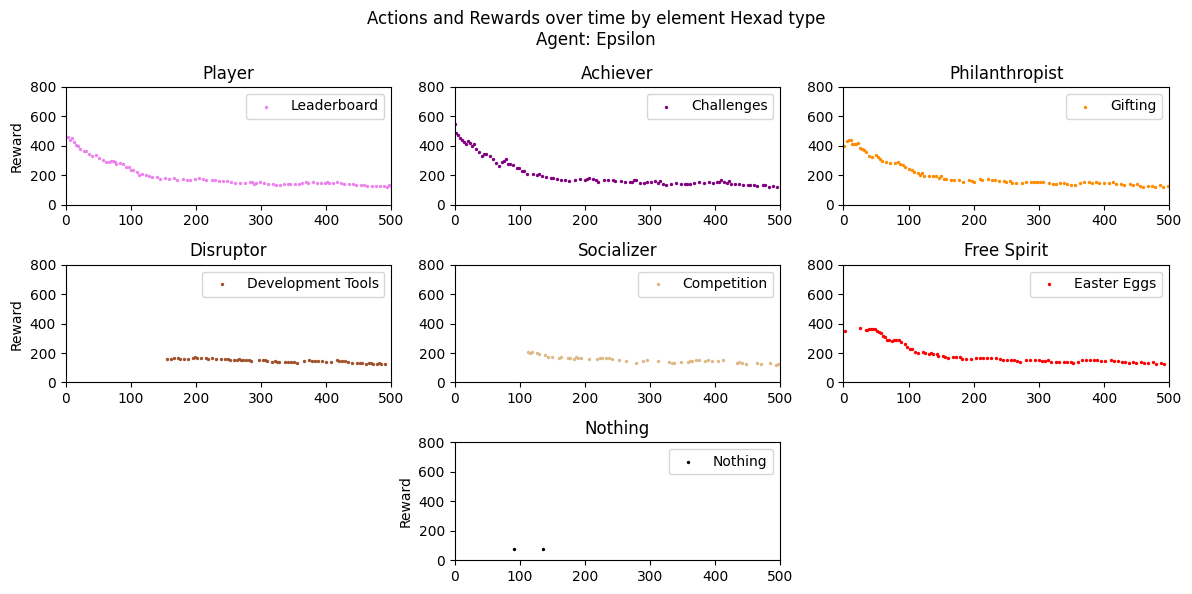

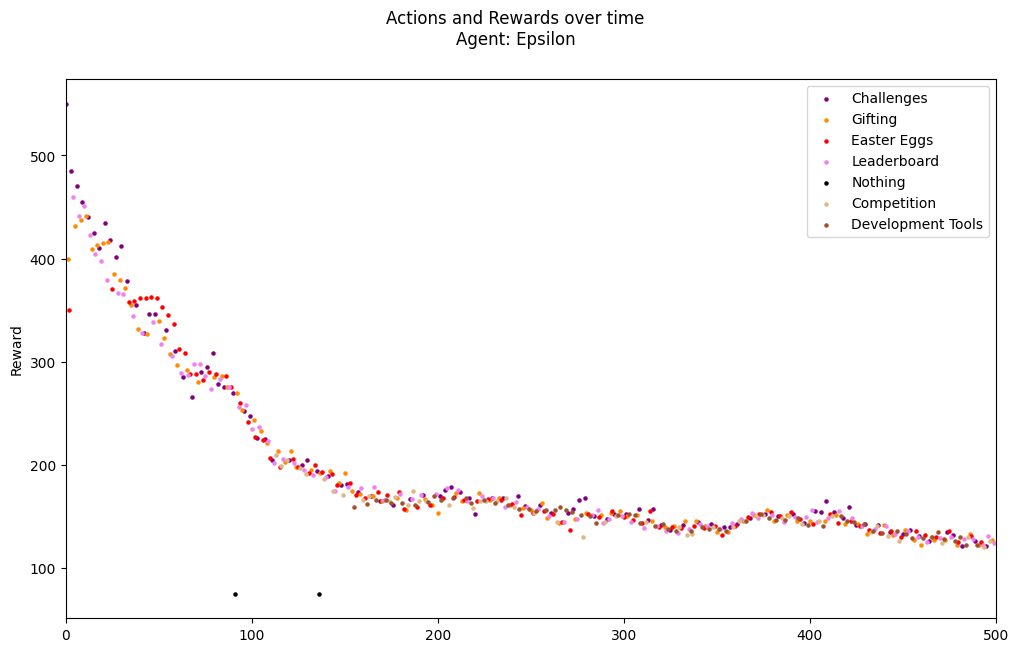

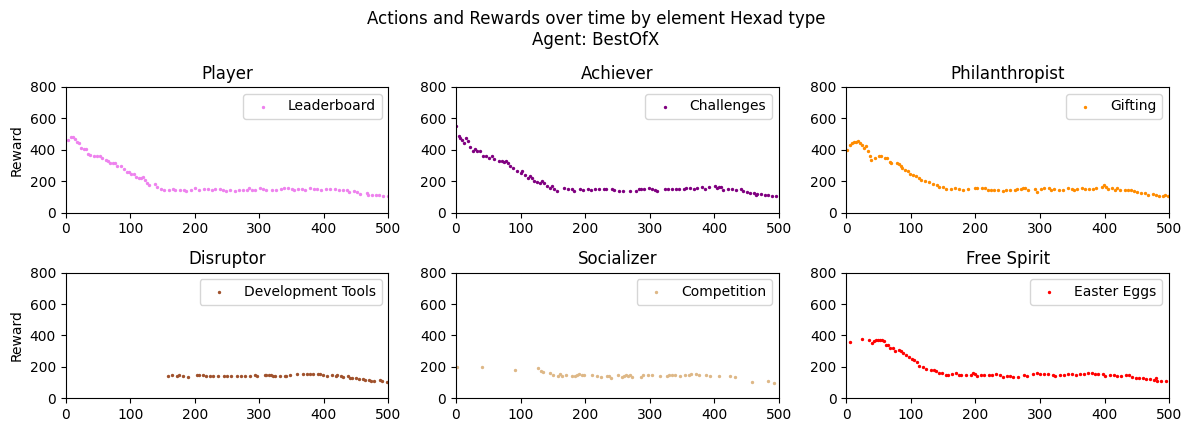

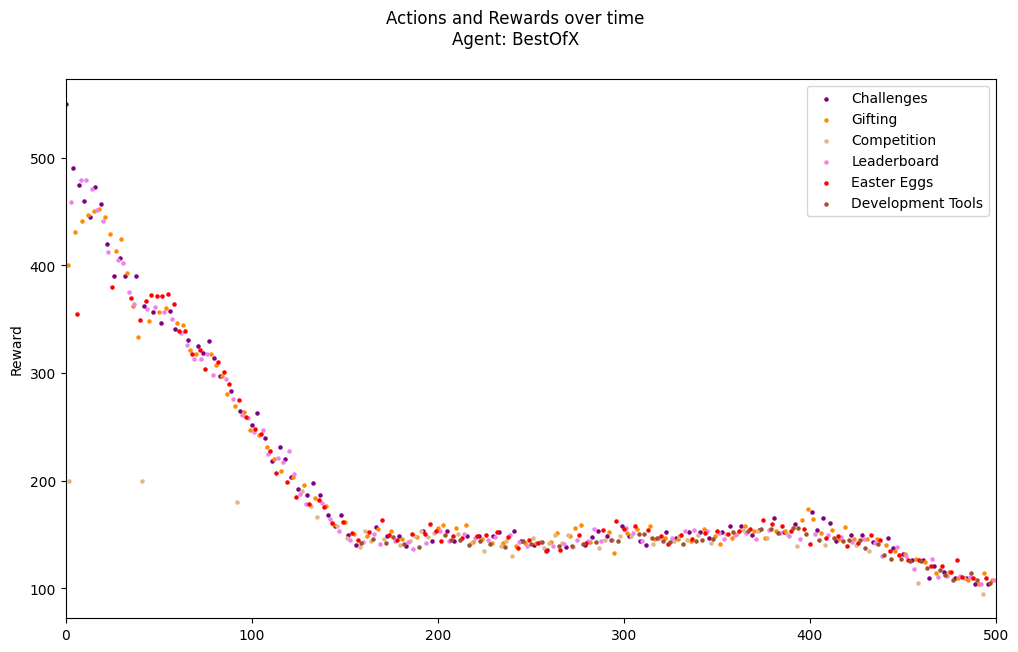

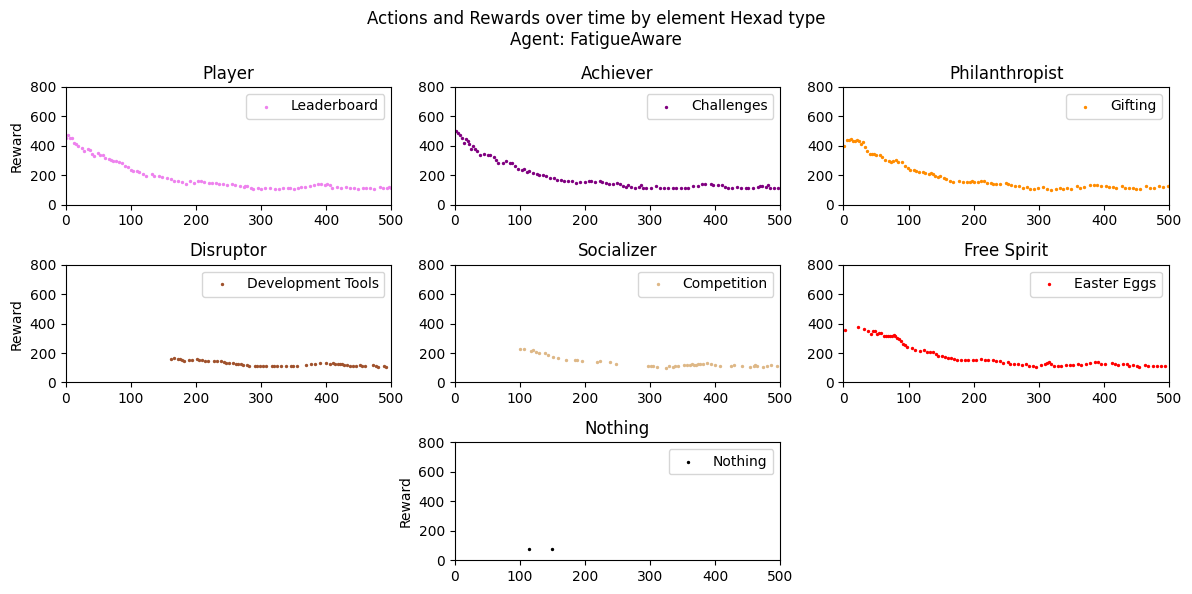

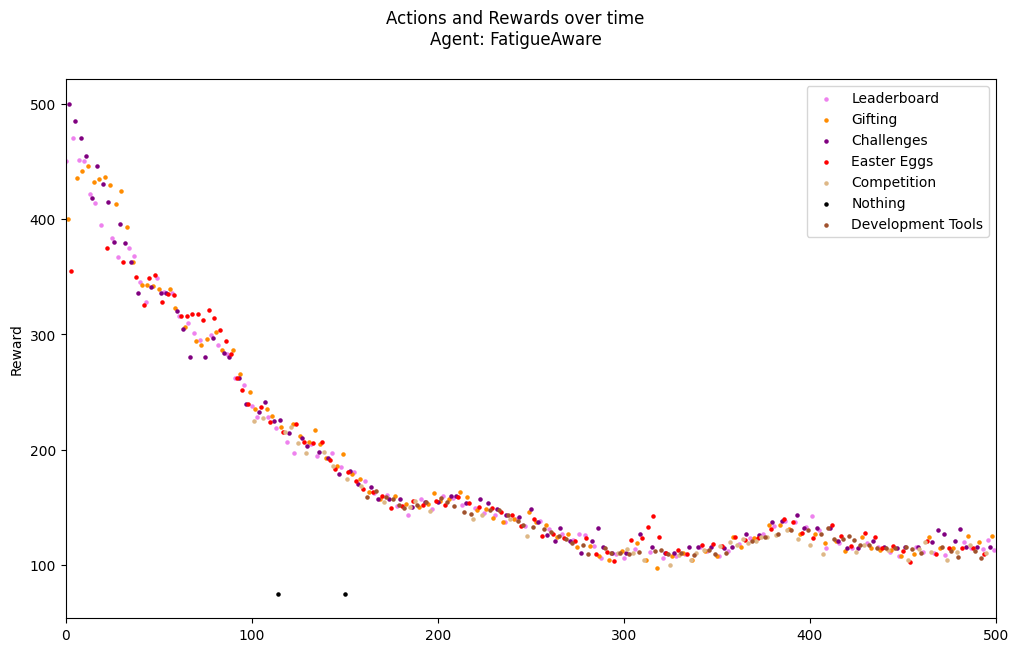

In [153]:
f = 1
for name, acts in actions.items():
    plot_actionsX(actions=acts, env=env, title=name.format(name), f=f, X=tests)
    f += 3

Text(0.5, 1.0, 'Agent Accuracy')

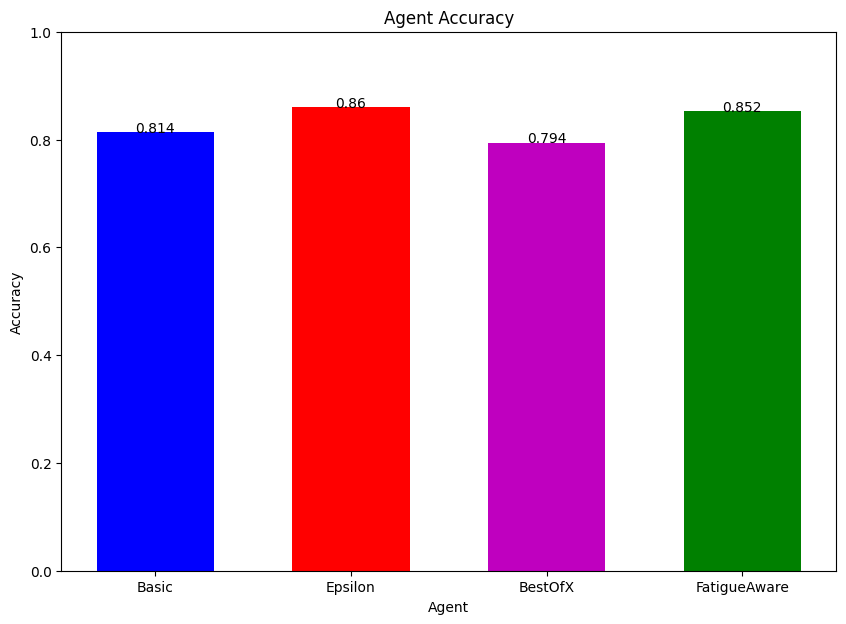

In [154]:
plt.bar(accuracies.keys(), accuracies.values(), color=["b", "r", "m", "g"], width=0.6)


def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha="center")


addlabels([*accuracies.keys()], [*accuracies.values()])
plt.xlabel("Agent")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.title("Agent Accuracy")

Text(0.5, 0, 'Agents')

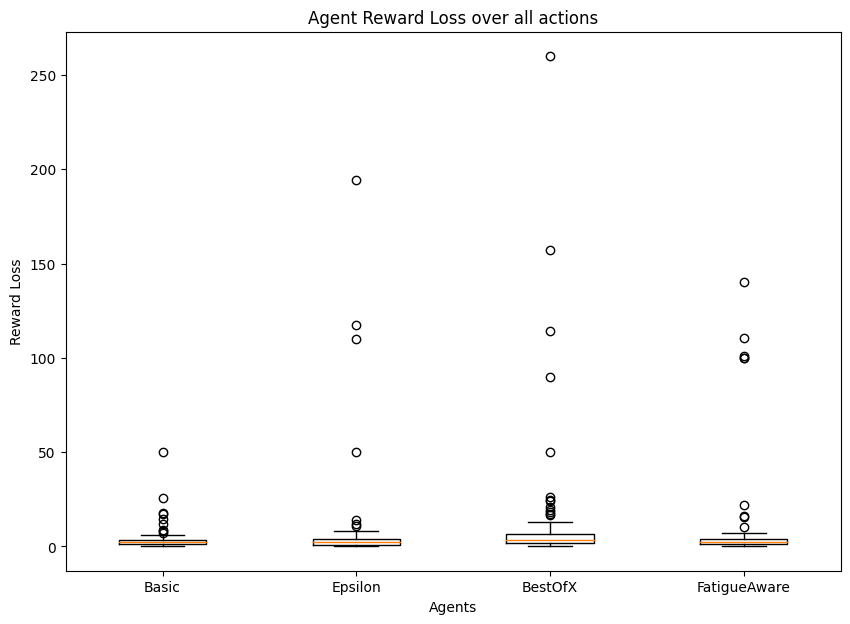

In [155]:
vs = diff_from_best.values()
vs2 = []
for i in vs:
    v = np.array(i)
    v = v[v > 0.1]
    vs2.append(v)
bp = plt.boxplot(vs2, labels=diff_from_best.keys())
plt.title("Agent Reward Loss over all actions")
plt.ylabel("Reward Loss")
plt.xlabel("Agents")

(0.0, 100.0)

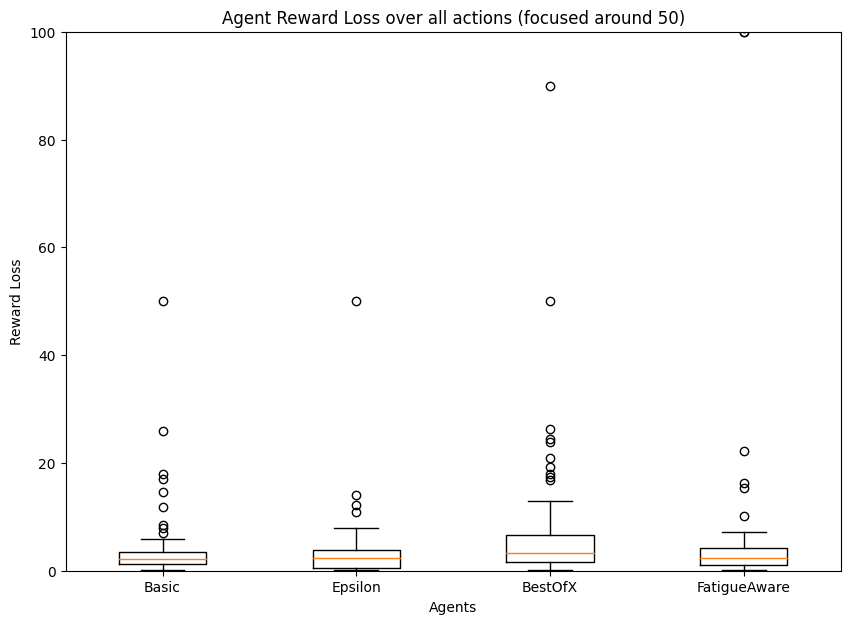

In [156]:
vs = diff_from_best.values()
vs2 = []
for i in vs:
    v = np.array(i)
    v = v[v > 0.1]
    vs2.append(v)
bp = plt.boxplot(vs2, labels=diff_from_best.keys())
plt.title("Agent Reward Loss over all actions (focused around 50)")
plt.ylabel("Reward Loss")
plt.xlabel("Agents")
plt.ylim(0,100)

<Figure size 1000x700 with 0 Axes>

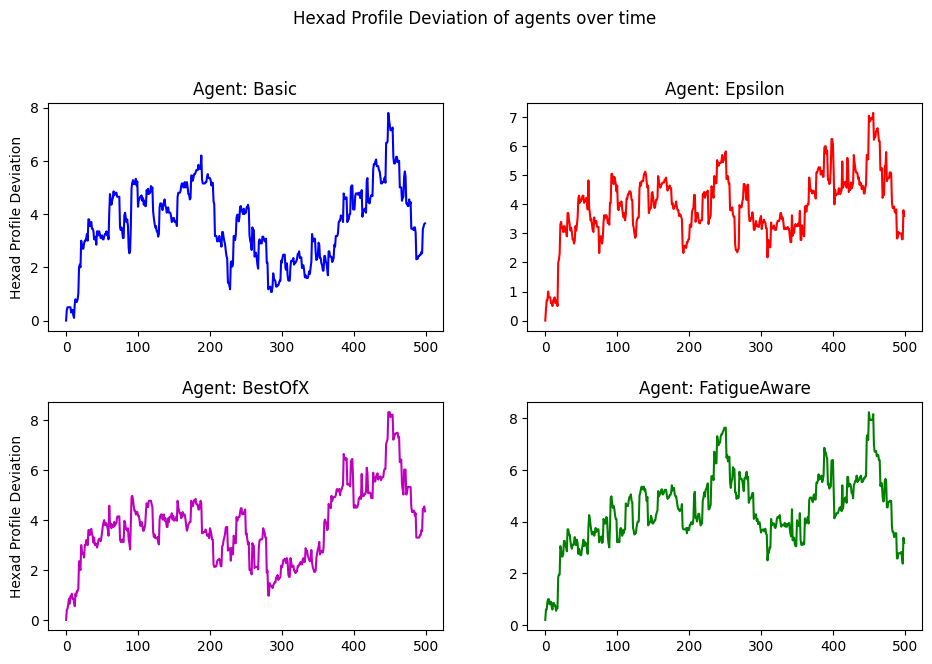

In [157]:
plt.figure()
plt.subplots(2, 2)
plt.suptitle(
    "Hexad Profile Deviation of agents over time"
)
plt.tight_layout(pad=3)
i = 1
cs = ["b", "r", "m", "g"]
for name in profile_diff:
    plt.subplot(2, 2, i)
    plt.plot(profile_diff[name], color=cs[i - 1])
    plt.title("Agent: {}".format(name))
    if i in [3, 4]:
        plt.xlabel("")
    if i in [1, 3]:
        plt.ylabel("Hexad Profile Deviation")
    i += 1